In [1]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

import sys
sys.path.append('..')

from run import Run
from run_db import db as run_db
from run_utils import init_runs, find_runs

tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

log_path = '/home/fiit/logs/'

runs = init_runs(log_path, run_db)

[('deepnet5', 441), ('deepnet2070', 548)]


In [3]:
def draw_graphs(runs, tasks, langs, role, metric=None, focused=False, label=None):
    
    if label is None:
        label = lambda run: f'{run.name}-{run.type}'
    
    fig, axes = plt.subplots(
        len(tasks),
        len(langs),
        figsize=(5*len(langs), 4*len(tasks)),
        squeeze=False)

    for ax_row, task in zip(axes, tasks):
        for ax, lang in zip(ax_row, langs):
            for run in runs:
                if not focused or run.config['focus_on'] == f'{task}-{lang}':
                    history = run.history(
                        metric=metric,
                        task=task,
                        language=lang,
                        role=role)
                    ax.plot(list(history), label=label(run))

    for ax, lang in zip(axes[0], langs):
        ax.set_title(lang)

    for ax, task in zip(axes[:, 0], tasks):
        ax.set_ylabel(task, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()

    
def results(runs, tasks, langs, focused=True, values_only=False):
    
    def get_results(run):
        out = {}
        for task, lang in itertools.product(tasks, langs):
            run.load()
            if not focused or run.config['focus_on'] == f'{task}-{lang}':
                res, epoch = run.metric_eval(task=task, language=lang)
                if res <= 1.01:
                    res *= 100
                out[(task, lang)] = res, epoch
        return out
    
    out = {
        run: get_results(run)
        for run in runs}
    
    if values_only:
        return [list(run.values())[0][0] for run in out.values()]
    else:
        return out

# tmp_runs = find_runs(runs, name='zero-shot-task-lang-ortho-10')
# res = results(tmp_runs, tasks, langs, focused=True)
# print(list(res.values()))

In [4]:
import numpy as np

def tempo(name, type='all'):    
    out = results(
        runs=find_runs(
            runs,
            type=type,
            name=name
        ),
        tasks=tasks,
        langs=langs,
        values_only=True
    )
    for value in out:
        print(f'{value:.2f} ', end='')
    print(np.round([np.mean(out[:4]), np.mean(out[4:8]), np.mean(out[8:])], decimals=2))


In [ ]:
two_by_two = results(
    runs=find_runs(
        runs,
        type='var',
        name='zero-shot-two-by-two'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

adv = results(
    runs=find_runs(
        runs,
        type='var',
        name='zero-shot-two-by-two-adversarial'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

for i, val in enumerate(two_by_two):
    print(f'{val:.2f}', end=' ')
    if i % 6 == 5:
        print(f'{adv[i // 6]:.2f}')

In [11]:
tempo('zero-shot', 'ml-3')
tempo('zero-shot', 'rel')
tempo('zero-shot')
tempo('zero-shot-400')
print()
tempo('zero-shot')
tempo('zero-shot-task')
tempo('zero-shot-lang')
tempo('zero-shot-task-lang-no-global')
tempo('zero-shot-task-lang')
print()
tempo('zero-shot-task-lang')
tempo('zero-shot-task-lang-ortho-10')
tempo('zero-shot-task-lang-ortho-25')
tempo('zero-shot-task-lang-ortho-50')
tempo('zero-shot-task-lang-ortho-100')
tempo('zero-shot-task-lang-ortho-200')
print()
tempo('zero-shot-task-lang-no-global')
tempo('zero-shot-task-lang-no-global-ortho-50')
tempo('zero-shot-task-lang-no-global-ortho-100')
tempo('zero-shot-task-lang-no-global-ortho-200')
print()
tempo('zero-shot')
tempo('zero-shot-task-emb')
tempo('zero-shot-lang-emb')
tempo('zero-shot-embs')
tempo('zero-shot-embs-400')
tempo('zero-shot-task-lang-both-embs')
print()
tempo('zero-shot', 'ml-3')
tempo('zero-shot')
tempo('zero-shot-embs')
tempo('zero-shot-task-lang')
print()
tempo('zero-shot-rotated', 'ml-3')
tempo('zero-shot-rotated')
tempo('zero-shot-embs-rotated')
tempo('zero-shot-task-lang-rotated')
tempo('zero-shot-rotated-adversarial')
print()
tempo('zero-shot-char-level', 'ml-3')
tempo('zero-shot-char-level')
tempo('zero-shot-embs-char-level')
tempo('zero-shot-task-lang-char-level')
tempo('zero-shot-char-level-adversarial')
print()
tempo('zero-shot')
tempo('zero-shot-adversarial')
tempo('zero-shot-adversarial-embs')
tempo('zero-shot-adversarial-task-lang')


30.47 44.76 47.75 32.02 40.17 55.91 47.83 53.27 65.78 77.66 75.05 57.72 [38.75 49.3  69.05]
33.39 43.37 42.19 30.59 45.61 60.49 50.18 56.22 76.32 78.95 80.87 73.21 [37.38 53.13 77.34]
43.61 54.03 44.38 42.97 49.11 62.71 53.12 61.54 83.12 85.02 83.40 84.81 [46.25 56.62 84.09]
44.83 56.08 50.71 46.38 52.53 63.76 52.87 60.99 81.49 86.25 83.30 86.39 [49.5  57.54 84.36]

43.61 54.03 44.38 42.97 49.11 62.71 53.12 61.54 83.12 85.02 83.40 84.81 [46.25 56.62 84.09]
49.54 57.50 53.45 52.26 46.78 60.81 52.86 60.94 86.73 86.62 82.47 89.78 [53.19 55.35 86.4 ]
43.55 52.70 54.30 52.26 45.55 64.55 54.03 61.14 74.89 82.79 78.18 76.49 [50.7  56.32 78.09]
51.29 59.22 58.05 59.85 48.45 64.84 51.38 60.87 83.85 86.84 82.43 87.46 [57.1  56.38 85.14]
52.35 59.90 58.58 60.65 49.63 64.72 53.51 62.35 85.55 87.19 82.35 88.71 [57.87 57.55 85.95]

52.35 59.90 58.58 60.65 49.63 64.72 53.51 62.35 85.55 87.19 82.35 88.71 [57.87 57.55 85.95]
52.62 60.34 59.05 61.11 48.68 63.43 53.70 62.73 84.94 87.71 82.69 89.00 [58.28

In [6]:
tempo('zero-shot')
tempo('zero-shot-adversarial')
tempo('zero-shot-embs')
tempo('zero-shot-task-lang')
print()
tempo('zero-shot-limited-task-200')
tempo('zero-shot-adversarial-limited-task-200')
tempo('zero-shot-embs-limited-task-200')
tempo('zero-shot-task-lang-limited-task-200')
print()
tempo('zero-shot-limited-lang-200')
tempo('zero-shot-adversarial-limited-lang-200')
tempo('zero-shot-embs-limited-lang-200')
tempo('zero-shot-task-lang-limited-lang-200')


43.61 54.03 44.38 42.97 49.11 62.71 53.12 61.54 83.12 85.02 83.40 84.81 [46.25 56.62 84.09]
55.44 60.04 57.80 62.83 49.47 64.84 53.09 61.64 82.62 86.56 83.61 86.38 [59.03 57.26 84.79]
54.41 60.81 58.09 60.51 50.44 64.50 53.49 61.75 82.40 85.72 84.21 87.17 [58.45 57.54 84.88]
52.35 59.90 58.58 60.65 49.63 64.72 53.51 62.35 85.55 87.19 82.35 88.71 [57.87 57.55 85.95]

40.72 48.44 43.66 40.00 45.78 56.23 48.61 53.78 78.65 82.17 83.31 82.21 [43.2  51.1  81.59]
49.81 54.56 52.13 55.22 46.07 58.93 48.33 50.12 78.40 80.81 81.00 83.29 [52.93 50.86 80.87]
46.48 51.56 51.79 53.23 44.44 56.90 50.85 52.68 78.36 82.45 83.07 81.95 [50.76 51.22 81.46]
41.47 48.86 47.09 52.06 47.31 56.52 51.64 47.46 81.94 82.56 79.40 84.78 [47.37 50.73 82.17]

41.31 49.11 45.63 47.50 40.44 49.13 52.16 51.73 80.76 81.61 83.58 80.49 [45.89 48.37 81.61]
50.23 57.92 55.10 58.59 46.40 61.05 51.44 58.40 81.56 85.01 84.19 85.74 [55.46 54.32 84.12]
45.77 54.28 53.78 53.95 42.00 46.02 50.15 51.99 78.40 81.61 82.29 80.55 [51.95

{'loss': 1.7785075, 'adv_loss': 0.6977284, 'gradient_norm': 1.0130074, 'unit_strength': 0.0008136771, 'ortho': 0.0, 'uas': 0.41540595890863447, 'las': 0.2552024839796525, 'language': 'cs', 'task': 'dep', 'role': 'train', 'epoch': 1}


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


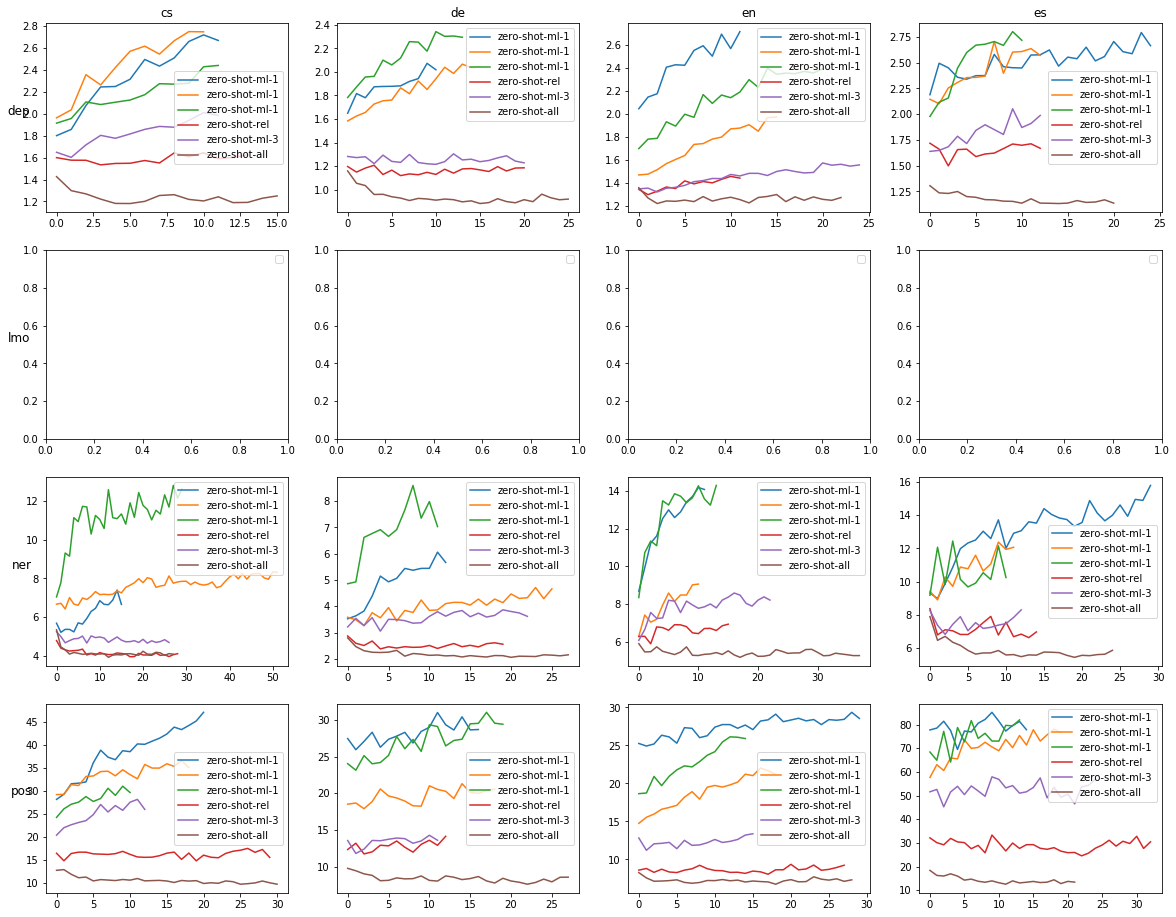

In [7]:
tmp = find_runs(runs, name='zero-shot')
print(tmp[0].data[0])
draw_graphs(tmp, tasks, langs, 'test', metric='loss', focused=True)


In [8]:
tmp = results(
    runs=find_runs(
        runs,
        type='var',
        name='low-resource'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

tmp2 = results(
    runs=find_runs(
        runs,
        type='var',
        name='low-resource-2'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

tmpa = results(
    runs=find_runs(
        runs,
        type='var',
        name='low-resource-advanced'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

adv = iter(tmpa)
baselines = iter(tmp[0::5] + tmp2[0::5])
bsl = next(baselines)

i = 0
for r in tmp:
    print(f'{r/bsl:.2f}', end=' ')
    i += 1
    if i % 5 == 0:
        for _ in range(3):
           print(f'{next(adv)/bsl:.2f}', end=' ')     
        print()
        bsl = next(baselines)
for r in tmp2:
    print(f'{r/bsl:.2f}', end=' ')
    i += 1
    if i % 5 == 0:
        for _ in range(3):
           print(f'{next(adv)/bsl:.2f}', end=' ')    
        print()
        bsl = next(baselines)



1.00 1.01 1.04 1.03 1.03 1.03 1.02 1.04 
1.00 1.02 1.02 1.04 1.05 1.03 1.03 1.04 
1.00 1.01 1.04 1.03 1.03 1.03 1.03 1.04 
1.00 1.02 1.07 1.15 1.12 1.12 1.09 1.14 
1.00 1.15 1.15 1.13 1.10 1.15 1.09 1.13 
1.00 1.03 1.02 1.11 1.11 1.09 1.08 1.08 
1.00 1.14 1.19 1.22 1.29 1.16 1.17 1.22 
1.00 0.98 0.97 1.01 1.02 0.94 1.01 1.02 
1.00 1.11 1.18 1.16 1.21 1.16 1.13 1.18 
1.00 1.02 1.02 1.04 1.05 1.05 1.05 1.05 
1.00 1.09 1.07 1.07 1.13 1.14 1.15 1.10 
1.00 1.02 1.02 1.05 1.05 1.05 1.05 1.04 
1.00 1.02 1.06 1.07 1.06 1.03 1.06 1.07 
1.00 1.03 1.09 1.14 1.14 1.10 1.09 1.10 
1.00 1.05 1.10 1.18 1.17 1.14 1.13 1.12 
1.00 1.06 1.05 1.14 1.11 1.07 1.08 1.07 
1.00 1.04 1.07 1.10 1.09 1.08 1.03 1.09 
1.00 1.01 1.03 1.03 1.03 1.02 1.03 1.03 
1.00 1.03 1.04 1.04 1.05 1.05 1.04 1.05 
1.00 1.05 1.26 1.31 1.33 1.29 1.25 1.24 


StopIteration: 

In [18]:
# low resource
data = """
1.00 1.01 1.04 1.03 1.03 1.03 1.02 1.04 
1.00 1.02 1.02 1.04 1.05 1.03 1.03 1.04 
1.00 1.01 1.04 1.03 1.03 1.03 1.03 1.04 
1.00 1.02 1.07 1.15 1.12 1.12 1.09 1.14 
1.00 1.15 1.15 1.13 1.10 1.15 1.09 1.13 
1.00 1.03 1.02 1.11 1.11 1.09 1.08 1.08 
1.00 1.14 1.19 1.22 1.29 1.16 1.17 1.22 
1.00 0.98 0.97 1.01 1.02 0.94 1.01 1.02 
1.00 1.11 1.18 1.16 1.21 1.16 1.13 1.18 
1.00 1.02 1.02 1.04 1.05 1.05 1.05 1.05 
1.00 1.09 1.07 1.07 1.13 1.14 1.15 1.10 
1.00 1.02 1.02 1.05 1.05 1.05 1.05 1.04 
1.00 1.02 1.06 1.07 1.06 1.03 1.06 1.07 
1.00 1.03 1.09 1.14 1.14 1.10 1.09 1.10 
1.00 1.05 1.10 1.18 1.17 1.14 1.13 1.12 
1.00 1.06 1.05 1.14 1.11 1.07 1.08 1.07 
1.00 1.04 1.07 1.10 1.09 1.08 1.03 1.09 
1.00 1.01 1.03 1.03 1.03 1.02 1.03 1.03 
1.00 1.03 1.04 1.04 1.05 1.05 1.04 1.05 
1.00 1.05 1.26 1.31 1.33 1.29 1.25 1.24 
""".strip()

# two by two
data_2 = """
1.00 1.17 0.98 1.65 1.71 1.76 1.48
1.00 1.11 1.02 1.13 1.15 1.08 1.25
1.00 1.04 0.93 1.07 1.12 0.85 1.31
1.00 1.06 1.00 1.10 1.21 1.11 1.64
1.00 1.03 1.03 1.02 1.02 1.03 1.04
1.00 0.82 1.00 1.30 1.78 1.46 2.35
1.00 0.97 0.96 1.04 1.46 0.97 1.80
1.00 0.92 0.96 1.00 1.01 1.10 1.05
1.00 1.10 1.02 1.24 1.25 0.79 1.50
1.00 1.08 1.00 1.04 1.09 1.05 1.16
1.00 1.08 1.00 1.58 1.53 0.73 1.70
1.00 1.14 1.11 1.18 1.18 1.13 1.26
1.00 1.08 1.02 1.34 1.38 1.39 1.38
1.00 0.91 1.01 1.08 1.42 0.76 2.41
1.00 1.13 0.98 1.18 1.68 1.57 1.68
1.00 0.89 1.02 0.88 1.21 1.07 1.37
1.00 0.98 0.95 1.04 1.07 0.99 1.01
1.00 1.11 0.96 1.12 1.12 0.89 1.18
1.00 1.10 1.03 1.17 1.17 1.23 1.22
1.00 0.95 0.94 1.38 1.84 1.87 2.10
""".strip()

data = np.array([np.fromstring(line.strip(), sep=' ') for line in data.split('\n')])
print(np.mean(data, axis=0))

data = data_2

data = np.array([np.fromstring(line.strip(), sep=' ') for line in data.split('\n')])
print(np.mean(data, axis=0))

[1.     1.0445 1.0745 1.1025 1.1085 1.0865 1.0805 1.0925]
[1.     1.0335 0.996  1.177  1.32   1.1415 1.4945]


In [16]:
tmp = results(
    runs=find_runs(
        runs,
        type='var',
        name='zero-shot-two-by-two'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

tmpa = results(
    runs=find_runs(
        runs,
        type='var',
        name='zero-shot-two-by-two-adversarial'
    ),
    tasks=tasks,
    langs=langs,
    values_only=True
)

baselines = iter(tmp[0::6])
bsl = next(baselines)
adv = iter(tmpa)

i = 0
for r in tmp:
    print(f'{r/bsl:.2f}', end=' ')
    i += 1
    if i % 6 == 0:
        print(f'{next(adv)/bsl:.2f}')   
        bsl = next(baselines)




1.00 1.17 0.98 1.65 1.71 1.76 1.48
1.00 1.11 1.02 1.13 1.15 1.08 1.25
1.00 1.04 0.93 1.07 1.12 0.85 1.31
1.00 1.06 1.00 1.10 1.21 1.11 1.64
1.00 1.03 1.03 1.02 1.02 1.03 1.04
1.00 0.82 1.00 1.30 1.78 1.46 2.35
1.00 0.97 0.96 1.04 1.46 0.97 1.80
1.00 0.92 0.96 1.00 1.01 1.10 1.05
1.00 1.10 1.02 1.24 1.25 0.79 1.50
1.00 1.08 1.00 1.04 1.09 1.05 1.16
1.00 1.08 1.00 1.58 1.53 0.73 1.70
1.00 1.14 1.11 1.18 1.18 1.13 1.26
1.00 1.08 1.02 1.34 1.38 1.39 1.38
1.00 0.91 1.01 1.08 1.42 0.76 2.41
1.00 1.13 0.98 1.18 1.68 1.57 1.68
1.00 0.89 1.02 0.88 1.21 1.07 1.37
1.00 0.98 0.95 1.04 1.07 0.99 1.01
1.00 1.11 0.96 1.12 1.12 0.89 1.18
1.00 1.10 1.03 1.17 1.17 1.23 1.22
1.00 0.95 0.94 1.38 1.84 1.87 2.10


StopIteration: 